In [37]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models

<br/>
<br/>

## Get the model and disable the parameters to do not train

In [12]:
vgg = models.vgg19(pretrained=True).features

# Stop the train for each parameter
for param in vgg.parameters():
    param.requires_grad_(False)

<br/>
<br/>

## Define the device CPU or GPU

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [50]:
def get_image(path, size = (500, 500)):
    transform_pipe = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    image = Image.open(path).convert('RGB')
    image = transform_pipe(image)[:3, :, :].unsqueeze(0)

    return image

In [51]:
content = get_image('./images/Recife.jpg')
style = get_image('./images/Surrealism.jpg')

In [52]:
def convert_tensor_to_img(tensor):

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

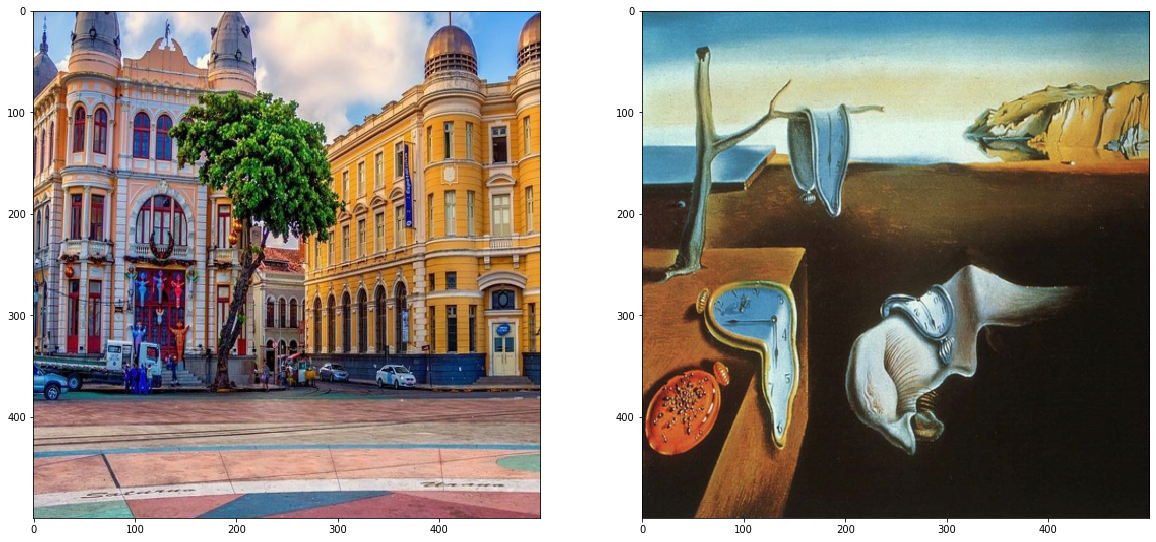

In [53]:
_, axis = plt.subplots(1, 2, figsize=(20, 10))

axis[0].imshow(convert_tensor_to_img(content))
axis[1].imshow(convert_tensor_to_img(style))